In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

Original number of features: 19
Reduced number of features after PCA: 6
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV accuracy: 0.4607582329317269
Classification Report (XGBoost with PCA and SMOTE):
                         precision    recall  f1-score   support

HighArousal_HighValence       0.33      0.23      0.27        78
 HighArousal_LowValence       0.49      0.55      0.52        78
 LowArousal_HighValence       0.50      0.51      0.51        78
  LowArousal_LowValence       0.49      0.58      0.53        78

               accuracy                           0.47       312
              macro avg       0.46      0.47      0.46       312
           weighted avg       0.46      0.47      0.46       312



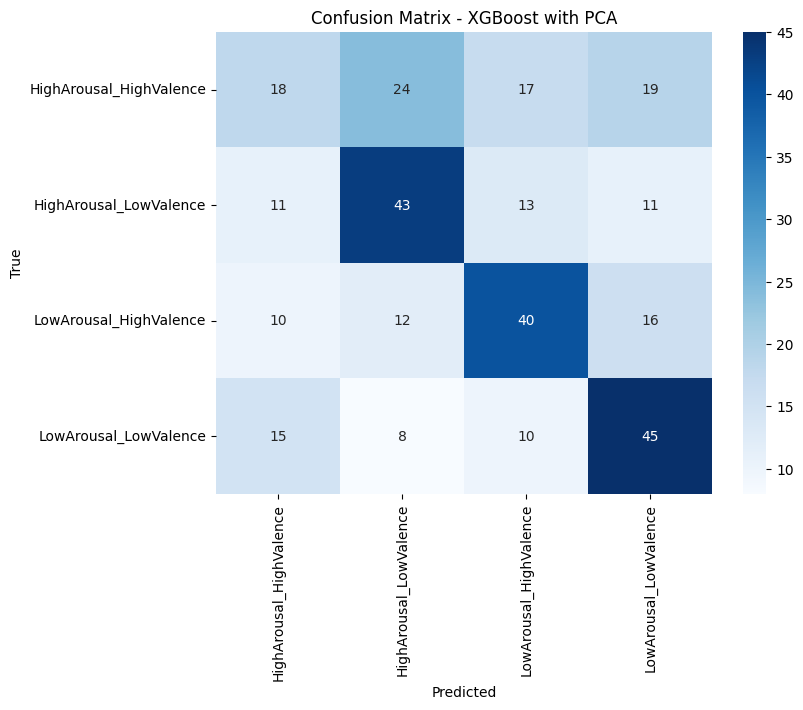

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # 需要安装 imbalanced-learn: pip install imbalanced-learn

file_path = 'deap_hrv_features.csv'
data = pd.read_csv(file_path)

# Encode labels
le = LabelEncoder()
data['Emotion_Category_Encoded'] = le.fit_transform(data['Emotion_Category'])

# Drop non-HRV and original label columns
data.drop(["Emotion_Category", 'Subject'], axis=1, inplace=True)

# Split into features and target
hrv_features = [col for col in data.columns if 'HRV_' in col]
X = data[hrv_features]
y = data['Emotion_Category_Encoded']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用SMOTE来平衡数据
sm = SMOTE(random_state=1)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# 划分训练测试集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, random_state=42, stratify=y_resampled)

# 使用XGBoost进行分类，并使用GridSearch进行超参寻优
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Classification Report (XGBoost with SMOTE):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 特征重要性
importances = best_xgb.feature_importances_
feature_importances = pd.DataFrame({'Feature': hrv_features, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette="viridis")
plt.title("Top 10 Feature Importances - XGBoost")
plt.show()




In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # 保留95%的数据变异
X_pca = pca.fit_transform(X_scaled)

# 查看PCA后的特征数量
print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

Original number of features: 19
Reduced number of features after PCA: 8


In [14]:
file_path = 'deap_hrv_features.csv'
data = pd.read_csv(file_path)
data.columns

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
       'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'Arousal', 'Valence',
       'Emotion_Category', 'Subject'],
      dtype='object')

In [13]:
import joblib

# 保存训练好的模型
model_filename = "xgboost_emotion_classifier.pkl"
joblib.dump(best_xgb, model_filename)

print(f"Model saved to {model_filename}")

Model saved to xgboost_emotion_classifier.pkl


In [11]:
%pip install imblearn


   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---------------------------------------- 258.3/258.3 kB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
